In [171]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import text
import re
import string
import joblib
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download("stopwords")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [172]:
# Load dataset
df_train = pd.read_csv('data/train.csv', encoding='Windows-1252')

# Quick preview of the data

# Convert the 'comment' column to string type
df_train["comment"] = df_train["comment"].astype(str)
df_train.head()


,comment,language,sentiment
0,nice and comfortable for longer rides hope it ...,English,positive
1,i just recieve my parcel thank you seller,English,positive
2,parcel was secured and well packed no damage o...,English,positive
3,the product is good and sealed the correct ite...,English,positive
4,quality ok,English,positive


In [173]:
print(df_train.shape)
print("")
df_train.info()

(3204, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    3204 non-null   object
 1   language   3204 non-null   object
 2   sentiment  3204 non-null   object
dtypes: object(3)
memory usage: 75.2+ KB


In [174]:
def lang_detect(text):
    # Custom Tagalog stop words
    tagalog_stopwords = [
        "akin", "aking", "ako", "alin", "am", "amin", "aming", "ang", "ano", "anumang", "apat", "at", "atin",
        "ating", "ay", "bababa", "bago", "bakit", "bawat", "bilang", "dahil", "dalawa", "dapat", "din", "dito",
        "doon", "gagawin", "gayunman", "ginagawa", "ginawa", "ginawang", "gumawa", "gusto", "habang", "hanggang",
        "huwag", "iba", "ibaba", "ibabaw", "ibig", "ikaw", "ilagay", "ilalim", "ilan", "inyong", "isa",
        "isang", "itaas", "ito", "iyo", "iyon", "iyong", "ka", "kahit", "kailangan", "kailanman", "kami", "kanila",
        "kanilang", "kanino", "kanya", "kanyang", "kapag", "kapwa", "karamihan", "katiyakan", "katulad", "kaya",
        "kaysa", "ko", "kong", "kulang", "kumuha", "kung", "laban", "lahat", "lamang", "likod", "lima", "maaari",
        "maaaring", "maging", "mahusay", "makita", "marami", "marapat", "masyado", "may", "mayroon", "mga", "minsan",
        "mismo", "mula", "muli", "na", "nabanggit", "naging", "nagkaroon", "nais", "nakita", "namin", "napaka", "narito",
        "nasaan", "ng", "ngayon", "ni", "nila", "nilang", "nito", "niya", "niyang", "noon", "o", "pa", "paano", "pababa",
        "paggawa", "pagitan", "pagkakaroon", "pagkatapos", "palabas", "pamamagitan", "panahon", "pangalawa", "para",
        "paraan", "pareho", "pataas", "pero", "pumunta", "pumupunta", "sa", "saan", "sabi", "sabihin", "sarili", "sila",
        "sino", "siya", "tatlo", "tayo", "tulad", "tungkol", "una", "walang", "nako", "nag", "pag", "thi", "una", "lng", "ga",
        "yung", "i", "doy", "ive", "kaso", "ma", "sana", "sya", "naman", "xa", "po", "lang", "lamang", "tapos", "bike", "kayo",
        "di","nga", "brake", "pads","kang"
    ]

    # Initialize CountVectorizer to get English stop words
    vectorizer = CountVectorizer(stop_words='english')
    english_stop_words = vectorizer.get_stop_words()  # Get the English stop words
    # Combine English and Tagalog stop words
    combined_stop_words = tagalog_stopwords + list(english_stop_words)

    # Create a new CountVectorizer with the combined stop words
    vectorizer_with_combined_stopwords = CountVectorizer(stop_words=combined_stop_words, preprocessor=pre_process, tokenizer=word_tokenize)
    
    return vectorizer_with_combined_stopwords

# data preprocessing
def pre_process(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s0-9]', '', text) # Remove special char and numbers
    text = re.sub(r'\s+', ' ', text).strip()# Remove extra whitespace
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d', '', text)   # Remove digits
    comment_review = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation

    return comment_review

# Calculate word count
def calculate_word_counts(texts):
    text_samples = texts.apply(lambda x: lang_detect(x).build_analyzer()(x))  # Detect language for each text
    all_texts = [' '.join(tokens) for tokens in text_samples]  # Join the tokens back into strings

    # Re-vectorize using the most common detected language (for simplicity)
    vectorizer = lang_detect(texts.iloc[0])  # Assume language detection from the first text
    X = vectorizer.fit_transform(all_texts)  # Fit and transform the vectorized text

    # Get word counts
    word_count_array = X.toarray().sum(axis=0)  # Sum word counts across all documents
    words = vectorizer.get_feature_names_out()  # Get feature names (words)
    
    word_count = dict(zip(words, word_count_array))# Create a dictionary mapping words to their counts
    
    return word_count

In [184]:
# Detect language from the first sample to decide vectorizer
text_review = df_train['comment'].iloc[0]
vectorizer = lang_detect(text_review)
print("Combined Stop Words in Vectorizer:", vectorizer.get_stop_words())
    
X = vectorizer.fit_transform(df_train['comment'])
y = df_train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1 ,random_state=42)

# Train Naive Bayes model
model = MultinomialNB()
model.fit(X, y)

y_pred = model.predict(X_test)

# Exports the model and vectorizer into .joblib

joblib.dump(model, 'Naive_Bayes_model.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')
# #loaded_model = joblib.load('Naive_Bayes_model.joblib')

Combined Stop Words in Vectorizer: frozenset({'at', 'siya', 'seem', 'tulad', 'lng', 'she', 'whoever', 'due', 'our', 'maaari', 'kanino', 'latterly', 'cannot', 'against', 'one', 'co', 'while', 'iyong', 'became', 'nowhere', 'yours', 'though', 'part', 'do', 'perhaps', 'tapos', 'lamang', 'din', 'dalawa', 'but', 'everyone', 'must', 'it', 'something', 'kapwa', 'kailanman', 'katiyakan', 'saan', 'habang', 'o', 'towards', 'whose', 'kaya', 'pataas', 'nako', 'well', 'katulad', 'would', 'behind', 'neither', 'tayo', 'nor', 'be', 'ni', 'sarili', 'because', 'less', 'mill', 'sino', 'then', 'any', 'or', 'over', 'was', 'own', 'brake', 'on', 'sixty', 'kaso', 'if', 'pababa', 'herself', 'every', 'with', 'nasaan', 'etc', 'few', 'ngayon', 'nito', 'ever', 'anyone', 'whether', 'otherwise', 'not', 'several', 'which', 'up', 'sya', 'ibabaw', 'karamihan', 'gagawin', 'formerly', 'are', 'ng', 'paraan', 'besides', 'cant', 'twelve', 'once', 'whenever', 'fifteen', 'ilalim', 'that', 'below', 'dahil', 'becomes', 'itaas', 

c:\Users\Mel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['vectorizer.joblib']

Confusion matrix, without normalization
[[695  60]
 [ 29 818]]
Normalized confusion matrix
[[0.92 0.08]
 [0.03 0.97]]


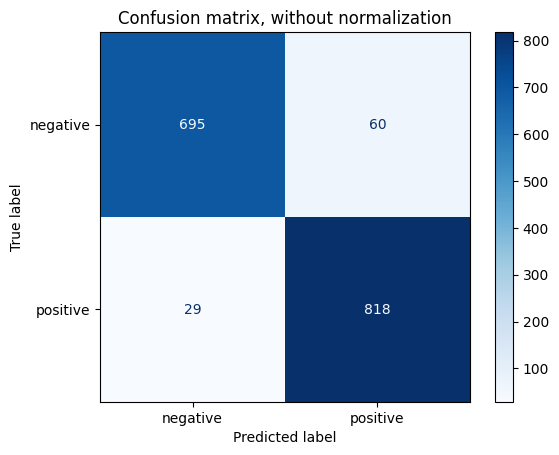

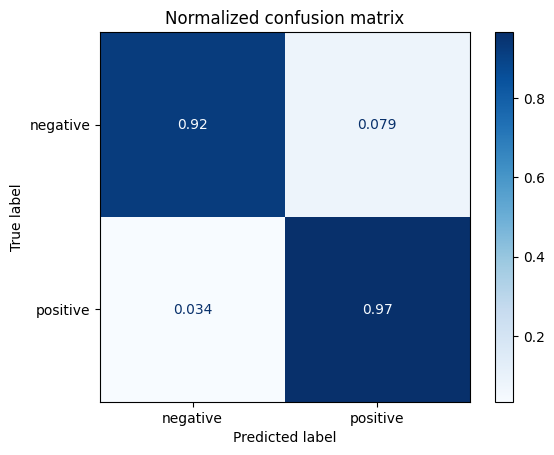

In [185]:
# Confusion matrix
classifier = svm.SVC(kernel="linear", C=1).fit(X_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


In [186]:
# classification report
report = classification_report(y_test, y_pred, labels=['positive', 'negative'])
print(report)

# Display Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

              precision    recall  f1-score   support

    positive       0.93      0.97      0.95       847
    negative       0.96      0.92      0.94       755

    accuracy                           0.94      1602
   macro avg       0.95      0.94      0.94      1602
weighted avg       0.94      0.94      0.94      1602

Accuracy Score: 0.94


In [178]:
# Calculate word counts for tweets with different sentiments
word_count_positive = calculate_word_counts(df_train[df_train['sentiment'] == 'positive']['comment'])
word_count_negative = calculate_word_counts(df_train[df_train['sentiment'] == 'negative']['comment'])
word_count_negative.items()

c:\Users\Mel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


dict_items([('able', np.int64(2)), ('abot', np.int64(4)), ('abroad', np.int64(1)), ('absorb', np.int64(5)), ('absorber', np.int64(2)), ('absorption', np.int64(2)), ('abutin', np.int64(1)), ('ac', np.int64(3)), ('accessories', np.int64(1)), ('accidentally', np.int64(1)), ('according', np.int64(4)), ('account', np.int64(2)), ('accurate', np.int64(1)), ('accurately', np.int64(2)), ('aches', np.int64(1)), ('action', np.int64(1)), ('active', np.int64(1)), ('activity', np.int64(1)), ('actual', np.int64(1)), ('adapter', np.int64(1)), ('adaptor', np.int64(1)), ('add', np.int64(2)), ('additional', np.int64(1)), ('address', np.int64(3)), ('addressnot', np.int64(1)), ('adi', np.int64(1)), ('adjust', np.int64(4)), ('adjusted', np.int64(1)), ('adjusting', np.int64(1)), ('adjustment', np.int64(4)), ('adjustments', np.int64(2)), ('admiral', np.int64(1)), ('advance', np.int64(1)), ('advertised', np.int64(2)), ('advertisements', np.int64(1)), ('advertising', np.int64(1)), ('advice', np.int64(1)), ('aff

In [179]:
# Convert word counts to DataFrames for better visualization
word_count_positive_df = pd.DataFrame(word_count_positive.items(), columns=['Word', 'Count'])
word_count_negative_df = pd.DataFrame(word_count_negative.items(), columns=['Word', 'Count'])

In [180]:
# Sort and select the top 20 words for each sentiment class
top_positive_words = word_count_positive_df.sort_values(by='Count', ascending=False).head(20)
top_negative_words = word_count_negative_df.sort_values(by='Count', ascending=False).head(20)

In [181]:
# Display the top words and their counts for each sentiment class
print("Word Counts - Positive Sentiment:")
print(top_positive_words.head())

print("\nWord Counts - Negative Sentiment:")
print(top_negative_words.head())

Word Counts - Positive Sentiment:
         Word  Count
712      good    553
1577  quality    328
1542  product    284
125    bagong    219
1771   seller    180

Word Counts - Negative Sentiment:
       Word  Count
1465    new    220
864   hindi    213
678    feel    130
1851  rides    129
927      im    122


In [182]:
# Display the top words for each sentiment class - Positive
print("Top 20 Words - Positive Sentiment:")
print()
# Apply background gradient styling and display the DataFrame
styled_positive_words = top_positive_words.style.background_gradient(cmap='Greens')
styled_positive_words

Top 20 Words - Positive Sentiment:



,Word,Count
712,good,553
1577,quality,328
1542,product,284
125,bagong,219
1771,seller,180
1319,new,170
606,fast,141
2045,thank,140
435,delivery,137
1801,shifters,129


In [183]:
# Display the top words for each sentiment class - Negative
print("\nTop 20 Words - Negative Sentiment:")
print()
# Apply background gradient styling and display the DataFrame
styled_negative_words = top_negative_words.style.background_gradient(cmap='Reds')
styled_negative_words



Top 20 Words - Negative Sentiment:



,Word,Count
1465,new,220
864,hindi,213
678,feel,130
1851,rides,129
927,im,122
135,bagong,110
2054,sobrang,93
1977,shifters,93
559,dont,92
556,doesnt,81
